# Generalizing Chunks
#### John R. Starr; jrs294@pitt.edu
Now that we have all of the data POS-tagged and chunked, it's time to generalize the chunks into categories: SOV, SVO, and an "extraneous" column EX (which will probably be filled by mis-parsed/mis-chunked data). At the most basic level, I intend on examining the number of noun phrases before the verb. If there are two, then we'll make it one. 

NOTE: I understand that the chunked data I have is by no means perfect; this is one of the limitations of my project.


### Table of Contents:
- [Section 1: Importing the Necessary Files, Examining Data](#Section-1:-Importing-Necessary-Files,-Examining-Data)
- [Section 2: Simplifying Chunks](#Section-2:-Simplifying-Chunks)
- [Section 3: Generalizing Chunks Using Regex](#Section-3:-Generalizing-Chunks-Using-Regex)
- [Section 4: Exporting Files](#Section-4:-Exporting-Files)


### Section 1: Importing the Necessary Files, Examining Data

In [1]:
import nltk
import numpy as np
import pandas as pd
import re

In [2]:
# Releasing all output:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
full_df = pd.read_pickle('tagged_chunked_df.pkl')

In [4]:
full_df.head()

,Eng,Far,Eng_Tok,Far_Tok,Eng_Len,Far_Len,Eng_Types,Far_Types,Far_POS,Far_Chunks,Eng_POS,Eng_Chunks
ID,,,,,,,,,,,,
1,raspy breathing,صداي خر خر,"[raspy, breathing]","[صداي, خر, خر]",2,3,"{raspy, breathing}","{صداي, خر}","[(صداي, NUM), (خر, Ne), (خر, N)]",[صداي خر خر NP],"[(raspy, NN), (breathing, NN)]","[[(raspy, NN), (breathing, NN)]]"
2,dad,پدر,[dad],[پدر],1,1,{dad},{پدر},"[(پدر, N)]",[پدر NP],"[(dad, NN)]","[[(dad, NN)]]"
3,maybe its the wind,شايد صداي باد باشه,"[maybe, its, the, wind]","[شايد, صداي, باد, باشه]",4,4,"{wind, maybe, the, its}","{صداي, شايد, باد, باشه}","[(شايد, Ne), (صداي, AJ), (باد, V), (باشه, V)]",[شايد صداي NP] [باد VP] [باشه VP],"[(maybe, RB), (its, PRP$), (the, DT), (wind, NN)]","[(maybe, RB), (its, PRP$), [(the, DT), (wind, ..."
4,no,نه,[no],[نه],1,1,{no},{نه},"[(نه, ADV)]",نه,"[(no, DT)]","[[(no, DT)]]"
5,stop please stop,دست نگه داريد خواهش ميکنم دست نگه داريد,"[stop, please, stop]","[دست, نگه, داريد, خواهش, ميکنم, دست, نگه, داريد]",3,8,"{please, stop}","{خواهش, دست, نگه, ميکنم, داريد}","[(دست, N), (نگه, N), (داريد, V), (خواهش, Ne), ...",[دست NP] [نگه داريد VP] [خواهش ميکنم دست NP] [...,"[(stop, JJ), (please, NN), (stop, VB)]","[[(stop, JJ), (please, NN)], [[('stop', 'VB')]]]"


Rather than working on the full DF, let's create a smaller one that we can run functions on faster...:

In [5]:
small_df = full_df.iloc[:100]

Let's see what type of data we're working with. Because we're looking for the abnormalities in Persian word order, we only need to focus on that data. So, what's it all look like?

In [6]:
# Gathering some information on the Persian data:
for item in small_df.Far_Chunks.iloc[:5]:
    print(item)
    print(item[0])
    print()

[صداي خر خر NP]
[

[پدر NP]
[

[شايد صداي NP] [باد VP] [باشه VP]
[

نه
ن

[دست NP] [نگه داريد VP] [خواهش ميکنم دست NP] [نگه داريد VP]
[



Ah.. it seems that our data is in string format...! This makes things a little more annoying to navigate. If only the data were in tuple form! Oh well...  Let's try use regex to search through this and get the word order that we want.

NOTE: Persian reads from right-to-left; however, the chunker flips the sentence backward so that it can be read "left-to-right" and can be more easily compared with languages like English. If this is confusing now, I'll explain more in my presentation.

### Section 2: Simplifying Chunks
First, I'll remove the brackets, and then I'll convert the data to a string and strip it of any excess characters.

In [7]:
# Creating Series of Chunks
full_gen = full_df.Far_Chunks.apply(lambda x: re.findall(r' [A-Z]+P\]', x))
full_gen.head()
len(full_gen)

ID
1                      [ NP]]
2                      [ NP]]
3          [ NP],  VP],  VP]]
4                          []
5    [ NP],  VP],  NP],  VP]]
Name: Far_Chunks, dtype: object

612086

In [8]:
# Removing brackets and lists
full_gen = full_gen.apply(str).apply(lambda x: re.sub(r"[,\[\]\']", '', x)).apply(lambda x: x.strip()).apply(lambda x: re.sub(r"'  '", '', x))

In [9]:
# Seeing our finalized head
full_gen.head()

ID
1                NP
2                NP
3        NP  VP  VP
4                  
5    NP  VP  NP  VP
Name: Far_Chunks, dtype: object

Now, let's see what our most common tags are using Counter:

In [10]:
from collections import Counter

chunk_tags_freq = Counter(full_gen)
chunk_tags_freq.most_common(15)

[('NP', 97417),
 ('NP  VP', 36201),
 ('NP  NP', 17290),
 ('VP', 14023),
 ('NP  NP  VP', 13694),
 ('NP  PP  NP  VP', 13342),
 ('NP  PP  NP', 11081),
 ('PP  NP', 8256),
 ('NP  VP  VP', 8138),
 ('PP  NP  VP', 7168),
 ('NP  VP  NP', 6901),
 ('NP  VP  NP  VP', 6462),
 ('NP  ADJP  VP', 6022),
 ('', 4384),
 ('ADVP  VP', 4176)]

The list is topped by a sole NP chunk, indicating that there are probably many one-word lines included in the corpus. Interestingly, strict SVO (with no inter-weaving phrases) is ranked ninth on this list! As expected, there should be many more SOV sentences than SVO ones. Let's visualize a bit:

In [11]:
pie_chart_values = chunk_tags_freq.most_common(10)
keys = [x[0] for x in pie_chart_values]
values = [x[1] for x in pie_chart_values]

In [12]:
import matplotlib.pyplot as plt

In [13]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

(-1.1053238751014764,
 1.1032728382717751,
 -1.1266115521514544,
 1.1025300406769927)

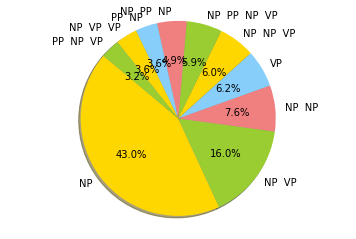

<Figure size 432x288 with 0 Axes>

In [14]:
pie = plt.pie(values, labels=keys, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

figure_1 = plt.figure()
figure_1.savefig('common_chunks.png')

In order to make sure that there aren't any oddball tags -- such as excess English words -- let's look at the set of tags. Ideally, there will only be NP, VP, PP, ADVP, ADJP, and POSTP.

In [15]:
# Making sure we have all the necessary tags!
tagset = set(' '.join(full_gen).split())

In [16]:
# Fingers crossed
%pprint
tagset

Pretty printing has been turned OFF


{'PP', 'VP', 'POSTP', 'ADVP', 'NP', 'ADJP'}

Looks great! All the expected tags are there. Now let's generalize the chunks using regex.

### Section 3: Generalizing Chunks Using Regex
First, let's create a bunch of sample chunks that we can test our functions on:

In [17]:
s1 = 'NP  VP'
s2 = 'NP  VP  NP'
s3 = 'NP  NP  VP'
s4 = 'NP  NP  VP  NP'
s5 = 'NP  PP  VP  NP'
s6 = 'NP  ADVP  VP  NP'
s7 = 'NP  ADVP  NP  VP'
s8 = 'NP  ADVP  PP  VP  NP'
s9 = 'NP  ADVP  PP  NP  VP'
s10 = 'NP  ADVP  PP  VP  ADVP  NP'

In [18]:
# Combining them into a list so that they can be looped through:
ls = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10]

Next, we need to define what NPs/VPs are _and_ aren't! This will help us create cleaner regular expressions that are freer in their selection:

In [19]:
# What they are:
np = r'NP'
vp = r'VP'

In [20]:
# What they're not:
not_np = r'((VP)|(POSTP)|(ADVP)|(PP)|(ADJP))'
not_vp = r'((NP)|(POSTP)|(ADVP)|(PP)|(ADJP))'
not_np_vp = r'((POSTP)|(ADVP)|(PP)|(ADJP))'

Now we'll create two regex patterns that should match for either SVO or SOV. Let's start with SVO:

In [21]:
# We're looking to match s2, s5, s6, s8, and s10.
svo_pat = re.compile(r'' + np +"  ("+ not_np_vp +"  )*" + vp +"  ("+ not_np_vp +"  )*" + np)

In [22]:
for item in ls:
    if svo_pat.match(item):
        print(item, (int(ls.index(item))+1))

NP  VP  NP 2
NP  PP  VP  NP 5
NP  ADVP  VP  NP 6
NP  ADVP  PP  VP  NP 8
NP  ADVP  PP  VP  ADVP  NP 10


Great! Now for SOV:

In [23]:
# We're hoping to match sentences 3, 4, 7, and 9.
sov_pat = re.compile(r'' + np +"  ("+ not_vp +"  )*" + np +"  ("+ not_vp +"  )*" + vp)

In [24]:
for item in ls:
    if sov_pat.match(item):
        print(item, (int(ls.index(item))+1))

NP  NP  VP 3
NP  NP  VP  NP 4
NP  ADVP  NP  VP 7
NP  ADVP  PP  NP  VP 9


Great! Now that the regex are in order, we can define a function using them:

In [25]:
def gen_word_order(text):
    if sov_pat.match(text): # Checking for SVO
        return 'SOV'
    elif svo_pat.match(text): # Checking for SOV
        return 'SVO'
    else:
        return 'Other'

In [26]:
test = full_gen.apply(gen_word_order)
test.value_counts()

Other    422525
SOV      120607
SVO       68954
Name: Far_Chunks, dtype: int64

Next, we need to make sure that the ordering of the rules isn't influencing the output. Let's check that now:

In [27]:
def gen_word_order2(text):
    if svo_pat.match(text): # Checking for SVO
        return 'SVO'
    elif sov_pat.match(text): # Checking for SOV
        return 'SOV'
    else:
        return 'Other'

In [28]:
test2 = full_gen.apply(gen_word_order2)
test2.value_counts()

Other    422525
SOV      120607
SVO       68954
Name: Far_Chunks, dtype: int64

Sweet -- the values stayed the same! Here's the final function that will be applied to full_df:

In [29]:
def gen_word_order_final(text):
    if sov_pat.match(text):
        return 'SOV'
    elif svo_pat.match(text):
        return 'SVO'
    else:
        return 'Other'

Now we'll apply the same process as we did to the testing series we created earlier:

In [30]:
# Removing Persian characters and excess English words:
full_df['Word_Order_P1'] = full_df.Far_Chunks.apply(lambda x: re.findall(r' [A-Z]+P\]', x))

In [31]:
# Making the data easier to manipulate:
full_df['Word_Order_P2'] = full_df['Word_Order_P1'].apply(str).apply(lambda x: re.sub(r"[,\[\]\']", '', x)).apply(lambda x: x.strip()).apply(lambda x: re.sub(r"'  '", '', x))

In [32]:
# Applying our function to generalize:
full_df['Word_Order_Final'] = full_df['Word_Order_P2'].apply(gen_word_order_final)

In [33]:
# Dropping the unnecessary columns:
full_df = full_df.drop(['Word_Order_P1', 'Word_Order_P2'], axis = 1)

What's the DF look like now? How many are classified for each of the three labels?

In [34]:
full_df.head()
full_df['Word_Order_Final'].value_counts()

,Eng,Far,Eng_Tok,Far_Tok,Eng_Len,Far_Len,Eng_Types,Far_Types,Far_POS,Far_Chunks,Eng_POS,Eng_Chunks,Word_Order_Final
ID,,,,,,,,,,,,,
1,raspy breathing,صداي خر خر,"[raspy, breathing]","[صداي, خر, خر]",2,3,"{raspy, breathing}","{صداي, خر}","[(صداي, NUM), (خر, Ne), (خر, N)]",[صداي خر خر NP],"[(raspy, NN), (breathing, NN)]","[[(raspy, NN), (breathing, NN)]]",Other
2,dad,پدر,[dad],[پدر],1,1,{dad},{پدر},"[(پدر, N)]",[پدر NP],"[(dad, NN)]","[[(dad, NN)]]",Other
3,maybe its the wind,شايد صداي باد باشه,"[maybe, its, the, wind]","[شايد, صداي, باد, باشه]",4,4,"{wind, maybe, the, its}","{صداي, شايد, باد, باشه}","[(شايد, Ne), (صداي, AJ), (باد, V), (باشه, V)]",[شايد صداي NP] [باد VP] [باشه VP],"[(maybe, RB), (its, PRP$), (the, DT), (wind, NN)]","[(maybe, RB), (its, PRP$), [(the, DT), (wind, ...",Other
4,no,نه,[no],[نه],1,1,{no},{نه},"[(نه, ADV)]",نه,"[(no, DT)]","[[(no, DT)]]",Other
5,stop please stop,دست نگه داريد خواهش ميکنم دست نگه داريد,"[stop, please, stop]","[دست, نگه, داريد, خواهش, ميکنم, دست, نگه, داريد]",3,8,"{please, stop}","{خواهش, دست, نگه, ميکنم, داريد}","[(دست, N), (نگه, N), (داريد, V), (خواهش, Ne), ...",[دست NP] [نگه داريد VP] [خواهش ميکنم دست NP] [...,"[(stop, JJ), (please, NN), (stop, VB)]","[[(stop, JJ), (please, NN)], [[('stop', 'VB')]]]",SVO


Other    422525
SOV      120607
SVO       68954
Name: Word_Order_Final, dtype: int64

Let's visualize!!

In [35]:
count_df = pd.DataFrame({'Word_Order': [440216, 120607 , 51263]},
                        index=['Other', 'SOV', 'SVO'])

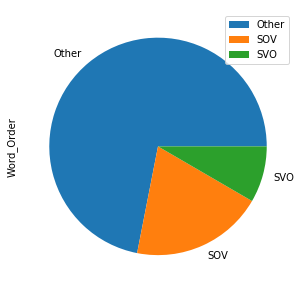

<Figure size 432x288 with 0 Axes>

In [36]:
count_df.plot.pie(y='Word_Order', figsize=(5, 5))
figure_2 = plt.figure()

figure_2.savefig('gen_word_order_pie.png')

Certainly, this isn't the most _ideal_ data -- nearly 75% of the data are labeled as "Other" (however, this is much better than attempts using regex, whose closet values were 83% labeled as "Other"). There are a few possible explanations for such a great deal of the data not being categorized as SOV or SVO:
- Chunker mischunked the data, therefore giving incorrect structures
- Regex are too restrictive in their selection (need editing)
- Various factors do not take into account the pro-drop nature of Persian
- Data itself consists of many one-word phrases that lack complex word order.

### Section 4: Exporting Files

In [37]:
booleans = []
for order in full_df['Word_Order_Final']:
    if order == 'Other':
        booleans.append(False)
    else:
        booleans.append(True)

In [38]:
# Checking the length
len(booleans)

612086

Now we'll turn this list into a Series so that way we can use it to organize the DF:

In [39]:
is_ordered = pd.Series(booleans)

Wait! The index for full_df starts at 1, not 0. Let's reset that:

In [40]:
full_df.reset_index(inplace = True)

Now to create the "ordered only" DF:

In [41]:
ordered_only_df = full_df[is_ordered]

In [42]:
ordered_only_df.head()

,ID,Eng,Far,Eng_Tok,Far_Tok,Eng_Len,Far_Len,Eng_Types,Far_Types,Far_POS,Far_Chunks,Eng_POS,Eng_Chunks,Word_Order_Final
4,5,stop please stop,دست نگه داريد خواهش ميکنم دست نگه داريد,"[stop, please, stop]","[دست, نگه, داريد, خواهش, ميکنم, دست, نگه, داريد]",3,8,"{please, stop}","{خواهش, دست, نگه, ميکنم, داريد}","[(دست, N), (نگه, N), (داريد, V), (خواهش, Ne), ...",[دست NP] [نگه داريد VP] [خواهش ميکنم دست NP] [...,"[(stop, JJ), (please, NN), (stop, VB)]","[[(stop, JJ), (please, NN)], [[('stop', 'VB')]]]",SVO
5,6,you have a week evans then well burn the house,اوانز تو فقط يک هفته وقت داري وگرنه خونتو خواه...,"[you, have, a, week, evans, then, well, burn, ...","[اوانز, تو, فقط, يک, هفته, وقت, داري, وگرنه, خ...",10,11,"{house, burn, the, have, evans, then, well, yo...","{خواهيم, وقت, داري, خونتو, اوانز, وگرنه, فقط, ...","[(اوانز, Ne), (تو, PRO), (فقط, ADV), (يک, Ne),...",[اوانز تو NP] [فقط يک هفته وقت ADVP] [داري VP]...,"[(you, PRP), (have, VBP), (a, DT), (week, NN),...","[(you, PRP), [[('have', 'VBP')], [('a', 'DT'),...",SVO
8,9,god damn it put that down,لعنت به تو اونو بذار زمين,"[god, damn, it, put, that, down]","[لعنت, به, تو, اونو, بذار, زمين]",6,6,"{damn, that, down, put, god, it}","{اونو, زمين, به, تو, لعنت, بذار}","[(لعنت, N), (به, P), (تو, PRO), (اونو, PRO), (...",[لعنت NP] [به PP] [تو NP] [اونو NP] [بذار VP] ...,"[(god, NN), (damn, VBZ), (it, PRP), (put, VBD)...","[[(god, NN)], [[('damn', 'VBZ')]], (it, PRP), ...",SOV
10,11,its the last feed weve got,اين آخرين علوفه اي بود که ما داشتيم,"[its, the, last, feed, weve, got]","[اين, آخرين, علوفه, اي, بود, که, ما, داشتيم]",6,8,"{got, the, its, last, feed, weve}","{اين, ما, علوفه, آخرين, اي, که, داشتيم, بود}","[(اين, Ne), (آخرين, NUM), (علوفه, N), (اي, N),...",[اين آخرين علوفه NP] [اي NP] [بود VP] که [ما N...,"[(its, PRP$), (the, DT), (last, JJ), (feed, NN...","[(its, PRP$), [(the, DT), (last, JJ), (feed, N...",SOV
13,14,herds over the ridge by now you go get cleaned up,گله را آوردم بيرون الان تو برو اونجا را تميز کن,"[herds, over, the, ridge, by, now, you, go, ge...","[گله, را, آوردم, بيرون, الان, تو, برو, اونجا, ...",11,11,"{herds, cleaned, ridge, go, the, now, you, by,...","{برو, اونجا, بيرون, گله, را, تو, کن, الان, آور...","[(گله, N), (را, POSTP), (آوردم, V), (بيرون, CO...",[گله NP] [را POSTP] [آوردم VP] بيرون [الان ADV...,"[(herds, NNS), (over, IN), (the, DT), (ridge, ...","[(herds, NNS), [[('over', 'IN')], [('the', 'DT...",SVO


Pickle time!

In [43]:
ordered_only_df.to_pickle('only_ordered_final.pkl')

In [44]:
other_only_df = full_df[full_df['Word_Order_Final'] == 'Other']
len(other_only_df)

422525

In [45]:
other_only_df.to_pickle('only_other_df.pkl')

And that's it for now...! Time for some data analysis!